In [1]:
from CUKG import CUKG
import opinion_dataset as random_dataset

import pandas as pd
import numpy as np

import tools
import matplotlib.pyplot as plt
import pickle

In [2]:
def print_variables(n_tasks,n_workers,percetage_tasks_workers,prob_worker,
                    confidence_worker,hard_labels,itt):
    print("n_tasks: ",n_tasks)
    print("n_workers: ",n_workers)
    print("percetage_tasks_workers: ",percetage_tasks_workers)
    print("prob_worker: ",prob_worker)
    print("confidence_worker: ",confidence_worker)
    print("hard_labels: ",hard_labels)
    print("itt: ",itt)
    return

In [3]:
def save_variables(save_file, n_tasks,n_workers,percetage_tasks_workers,prob_worker,
                    confidence_worker,hard_labels,itt):
    with open(save_file+"compare_workers_variables.txt", "w") as file:
        file.write("n_tasks: " + str(n_tasks) + "\n")
        file.write("n_workers: " + str(n_workers) + "\n")
        file.write("percetage_tasks_workers: " + str(percetage_tasks_workers) + "\n")
        file.write("prob_worker: " + str(prob_worker) + "\n")
        file.write("confidence_worker: " + str(confidence_worker) + "\n")
        file.write("hard_labels: " + str(hard_labels) + "\n")
        file.write("itt: " + str(itt) + "\n")
    return

In [4]:
def save_results(save_file,final_responses, final_labels, final_accuracies, final_errors):
    results = [save_file,final_responses, final_labels, final_accuracies, final_errors]
    with open(save_file+'compare_workers_results.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

In [18]:
def plot_experiment(data_points, x_label, 
                    title="", labels=['Excellent', 'No-confident', 'Malicious', 'No-accurate', 'Realistic', 'Random', 'Delusional'], 
                    colors=['blue', 'cyan', 'red', 'pink', 'green', 'black', 'purple', 'orange', 'yellow'], 
                    y_label="Error", custom_x_labels=['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], main_worker=0, min_y =0, max_y=1, save_file = "./"):
    
    num_points = len(data_points[0])
    experiments_per_point = len(data_points[0][0])

    #Step 1: Prepare data
    means = []
    data = np.array(data_points)
    std_dev = []
    for i, d in enumerate(data_points):
        means.append(np.mean(data[i], axis=1))
        std_dev.append(np.std(data[i], axis=1))
    
    # Step 2: Create the line plots with error bars (for std deviation)
    x = np.arange(num_points)
    fig, ax = plt.subplots(figsize=(12, 6))  # Make sure `ax` is used here
    plt.tight_layout()
    for i, (m, l, c) in enumerate(zip(means, labels, colors)):
        if i >= main_worker:
            l = labels[i+1]
            c = colors[i+1]
        ax.plot(x, m, label=l, color=c, marker='o')
        
    # Adding labels and title
    ax.set_xlabel(x_label, fontsize=28)
    ax.set_ylabel(y_label, fontsize=28)
    # Increase the font size for tick labels
    ax.tick_params(axis='both', which='major', labelsize=28)  # 'both' affects both x and y axes

    # Set the y-axis limits from 0.1 to 0.5
    plt.ylim(min_y, max_y)

    if title != "":
        ax.set_title(title)
    plt.legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.5, 0.25), ncol=3)
    
   #Custom x-axis labels
    if custom_x_labels != "":
        ax.set_xticks(x)
        ax.set_xticklabels(custom_x_labels, rotation=45, ha="right")  # Rotate x-axis tick labels 45 degrees for readability

    #save
    plt.savefig(save_file+"compare_workers-"+labels[main_worker]+"-"+y_label+".pdf",bbox_inches='tight')
    
    # Step 5: Show the plot
    plt.show()

In [6]:
#prob_worker = ([[type_worker_x0,type_worker_x1,...] , [type_worker_y0,type_worker_y1,...], ...] -> experiments x, y...
def run_experiment_random_datasets(n_tasks=20, n_workers=5, percetage_tasks_workers=1,
                                   prob_worker=[[0.3,0.1],[0.3,0.1],[0.8,0.1],[0.8,0.1],[-1,-1],[-1,-1],[-1,-1]],
                                   confidence_worker=[[0.8,0.1],[0.3,0.1],[0.8,0.1],[0.3,0.1],[-1,0.1],[-1,-1],[0.8,0.1]],hard_labels=False, itt=30, save_file="./"):

    print_variables(n_tasks,n_workers,percetage_tasks_workers,prob_worker,confidence_worker,hard_labels,itt)
    save_variables(save_file, n_tasks,n_workers,percetage_tasks_workers,prob_worker,confidence_worker,hard_labels,itt)
    

    final_accuracies = []
    final_errors = []
    final_labels = []
    final_responses = []
    for main_worker in range(len(prob_worker)):
        other_workers = list(range(len(prob_worker)))
        other_workers.remove(main_worker)
        accuracies = []
        errors = []
        labels = []
        responses = []
        for count2, other_worker in enumerate(other_workers):
            accuracy = []
            error = []
            label = []
            response = []
            for j in range(11):
                prob_type_worker = [0] * len(prob_worker)
                prob_main_worker = j/10
                prob_other_worker = 1 - prob_main_worker
                prob_type_worker[main_worker] =  prob_main_worker
                    
                prob_type_worker[other_worker] = prob_other_worker
                
                accu = []
                erro = []
                labe = []
                respo = []
                
                for i in range(itt):
                    lbls, workers_opinions, confidence_opinions, probabilities = random_dataset.generate_dataset(n_tasks,n_workers,percetage_tasks_workers,
                                                                                                                   prob_type_worker,prob_worker,confidence_worker,hard_labels)
                    accs = []
                    errs = []
                    res = []
                    
                    classifier = CUKG()
                    r = classifier.run(confidence_opinions, workers_opinions)
    
                    acc = tools.calculate_accuracy(lbls, r)
                    err = tools.calculate_avg_error(lbls, r)
    
                    accu.append(acc)
                    erro.append(err)
                    respo.append(r)
                    labe.append(lbls)
                    
                    total = itt*11*len(prob_worker)*len(other_workers)
                    current = i + (j*itt) + (count2*itt*11) + (main_worker*len(other_workers)*11*itt) 
                    percentage = (current/total) * 100
                    print(f"\rProgress: {percentage:.2f}%", end="")

                accuracy.append(accu)
                error.append(erro)
                response.append(respo)
                labels.append(labe)
                    
            responses.append(response)
            labels.append(label)
            accuracies.append(accuracy)
            errors.append(error)
            
        final_responses.append(responses)
        final_labels.append(labels)
        final_accuracies.append(accuracies)
        final_errors.append(errors)

    save_results(save_file,final_responses, final_labels, final_accuracies, final_errors)

    return final_responses, final_labels, final_accuracies, final_errors

In [7]:
save_file = "/home/su_dalle-lucca-tosi/Jupyter_notebooks/CrowdSource/compare_workers/"

In [8]:
result = run_experiment_random_datasets(itt=30, save_file=save_file)

final_responses, final_labels, final_accuracies, final_errors = result

n_tasks:  20
n_workers:  5
percetage_tasks_workers:  1
prob_worker:  [[0.3, 0.1], [0.3, 0.1], [0.8, 0.1], [0.8, 0.1], [-1, -1], [-1, -1], [-1, -1]]
confidence_worker:  [[0.8, 0.1], [0.3, 0.1], [0.8, 0.1], [0.3, 0.1], [-1, 0.1], [-1, -1], [0.8, 0.1]]
hard_labels:  False
itt:  30
Progress: 99.99%

In [9]:
'''
with open(save_file + 'compare_workers_results.pickle', 'rb') as handle:
    result = pickle.load(handle)

final_responses, final_labels, final_accuracies, final_errors = result
'''

"\nwith open(save_file + 'compare_workers_results.pickle', 'rb') as handle:\n    result = pickle.load(handle)\n\nfinal_responses, final_labels, final_accuracies, final_errors = result\n"

### Plot dimensions

In [10]:
#Error plot
np_errors = np.array(final_errors)
np_avg_errors = np.mean(np_errors, axis=3)
min_error = np_avg_errors.min() - 0.10
max_error = np_avg_errors.max() + 0.01

#Acc plot
np_acc = np.array(final_errors)
np_avg_accs = np.mean(np_acc, axis=3)
min_acc = np_avg_accs.min() - 0.15
max_acc = np_avg_accs.max() + 0.01

# Plots

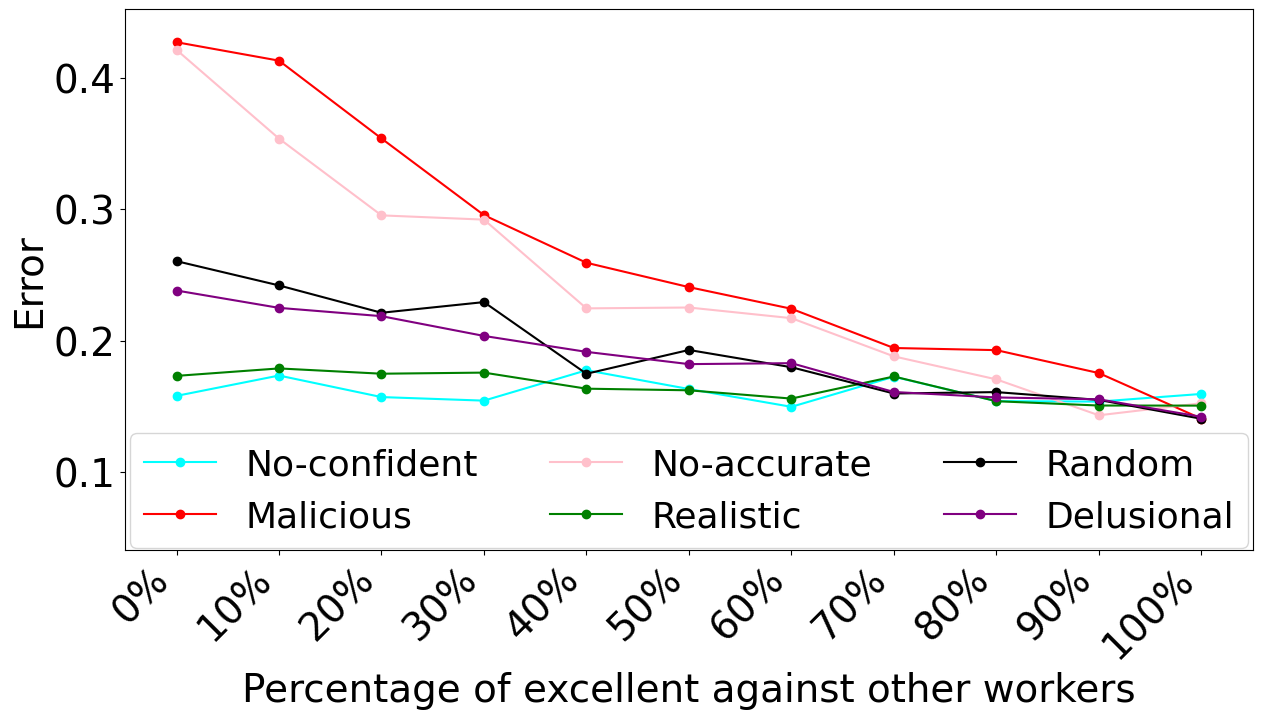

In [19]:
main_worker = 0
plot_experiment(final_errors[main_worker], "Percentage of excellent against other workers", main_worker=main_worker, min_y=min_error, max_y=max_error, save_file=save_file)

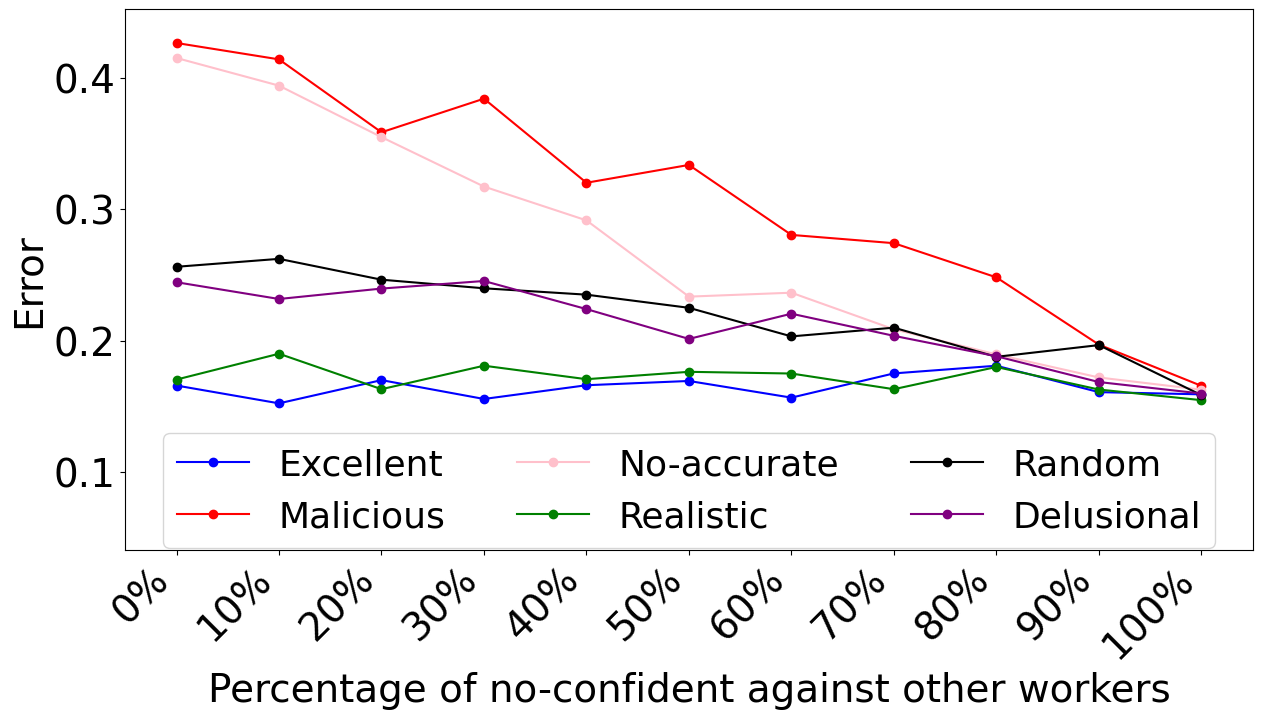

In [20]:
main_worker = 1
plot_experiment(final_errors[main_worker], "Percentage of no-confident against other workers", main_worker=main_worker, min_y=min_error, max_y=max_error, save_file=save_file)

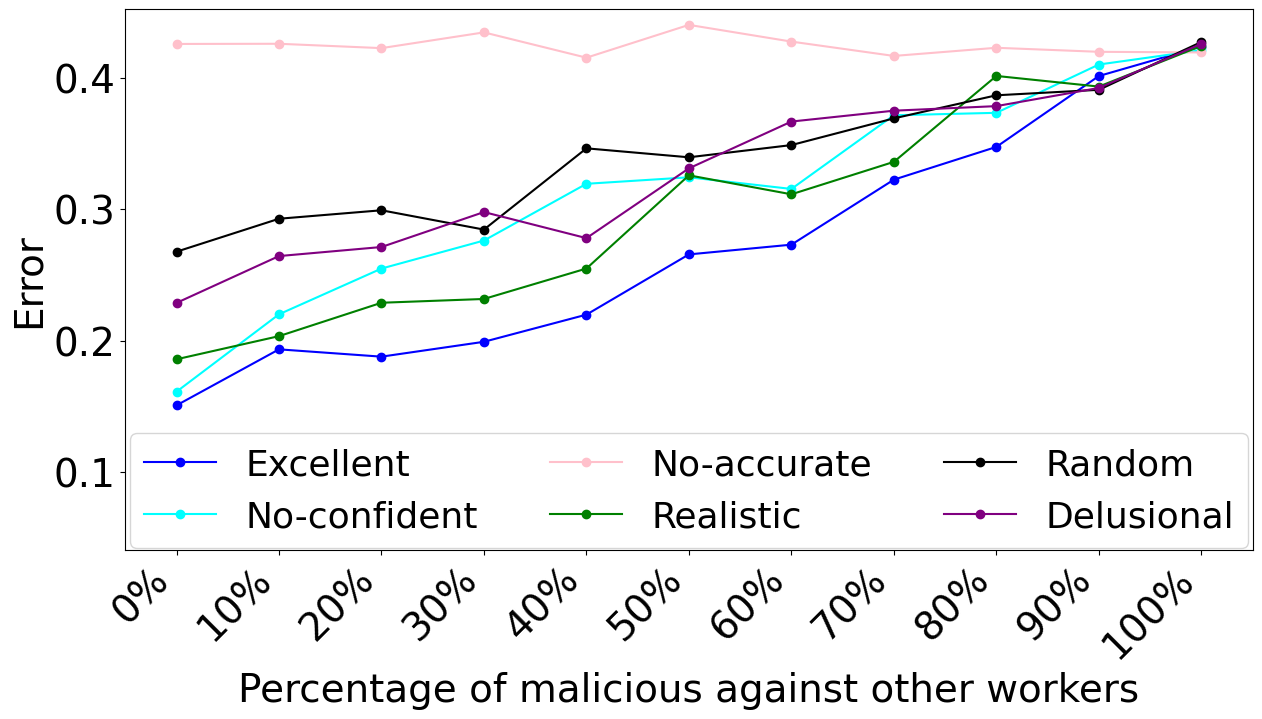

In [21]:
main_worker = 2
plot_experiment(final_errors[main_worker], "Percentage of malicious against other workers", main_worker=main_worker, min_y=min_error, max_y=max_error, save_file=save_file)

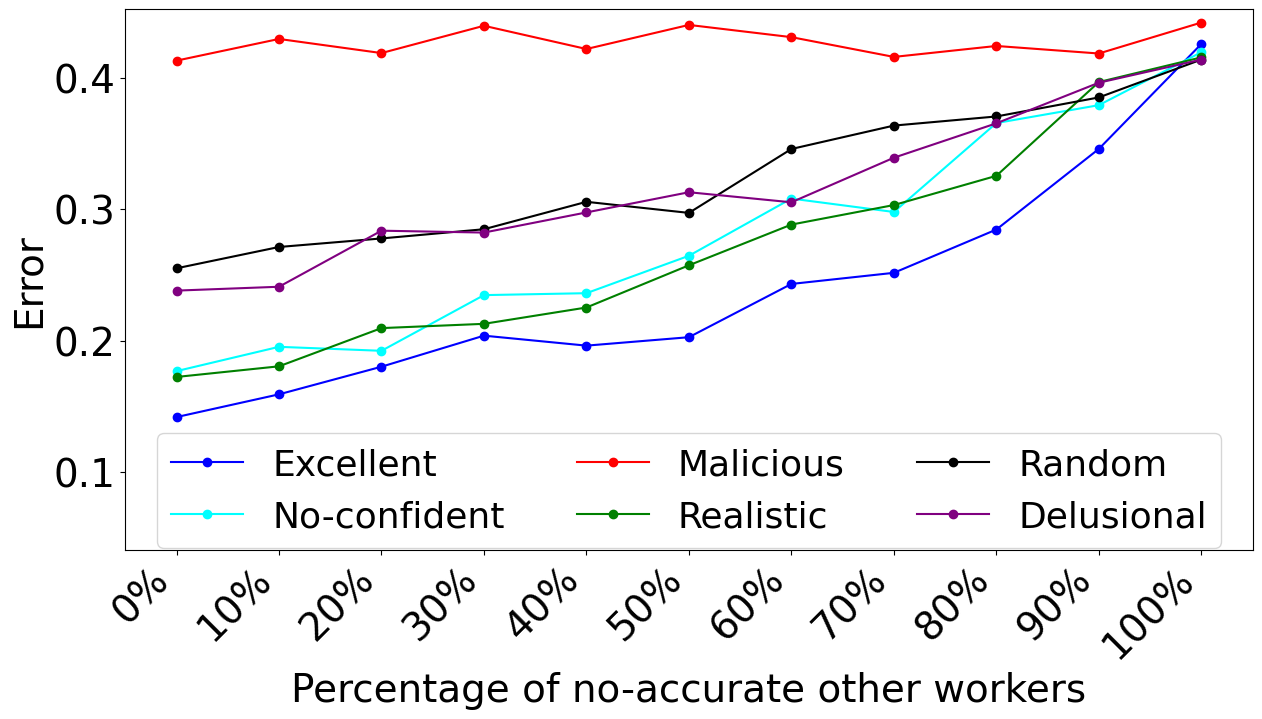

In [22]:
main_worker = 3
plot_experiment(final_errors[main_worker], "Percentage of no-accurate other workers", main_worker=main_worker, min_y=min_error, max_y=max_error, save_file=save_file)

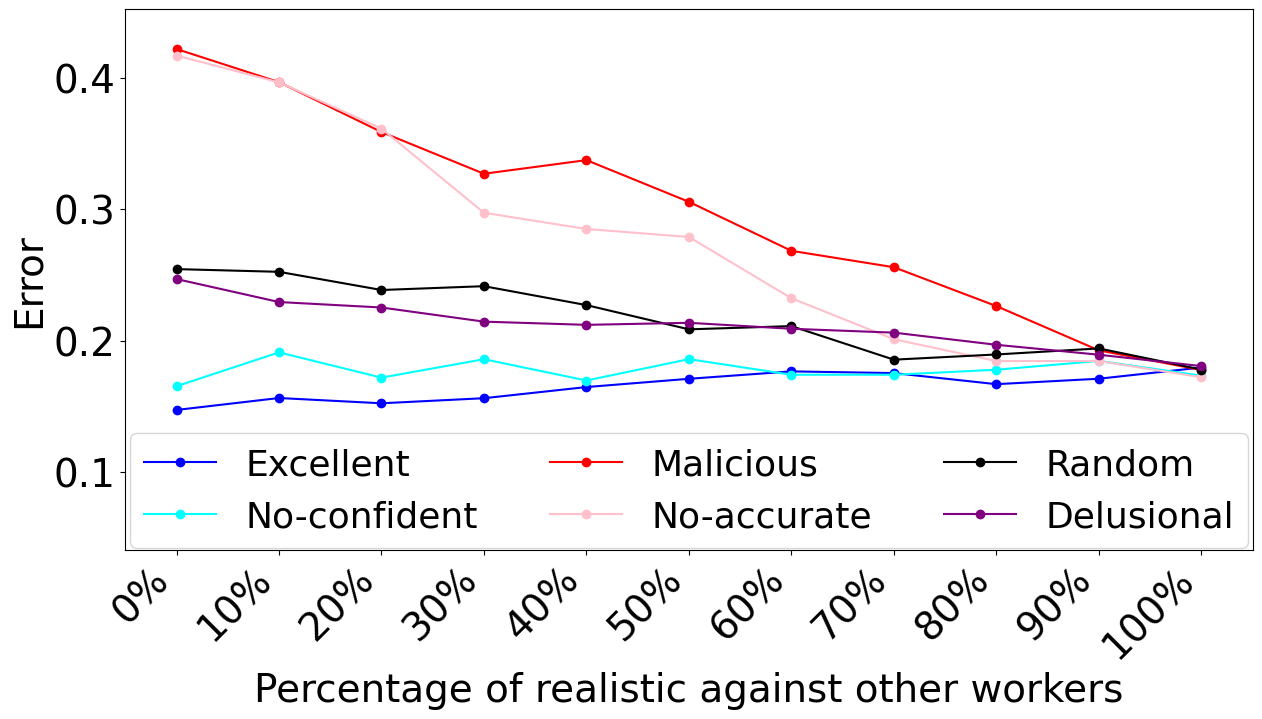

In [23]:
main_worker = 4
plot_experiment(final_errors[main_worker], "Percentage of realistic against other workers", main_worker=main_worker, min_y=min_error, max_y=max_error, save_file=save_file)

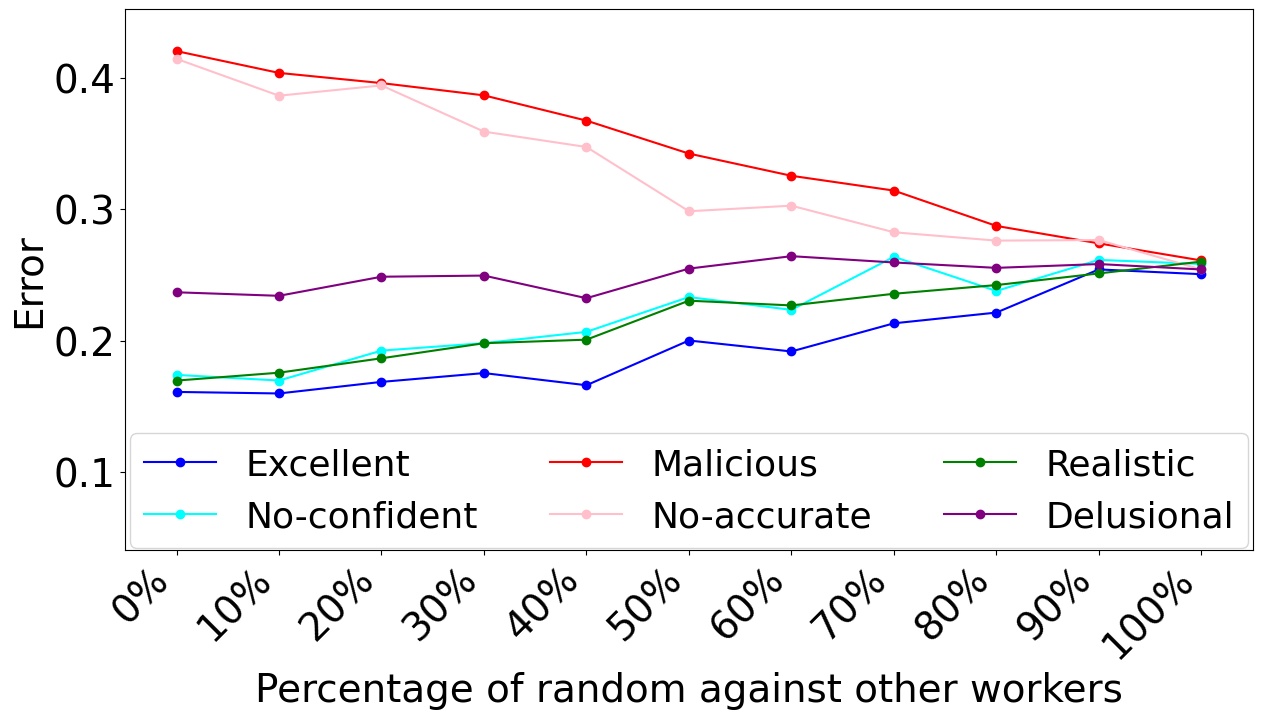

In [24]:
main_worker = 5
plot_experiment(final_errors[main_worker], "Percentage of random against other workers", main_worker=main_worker, min_y=min_error, max_y=max_error, save_file=save_file)

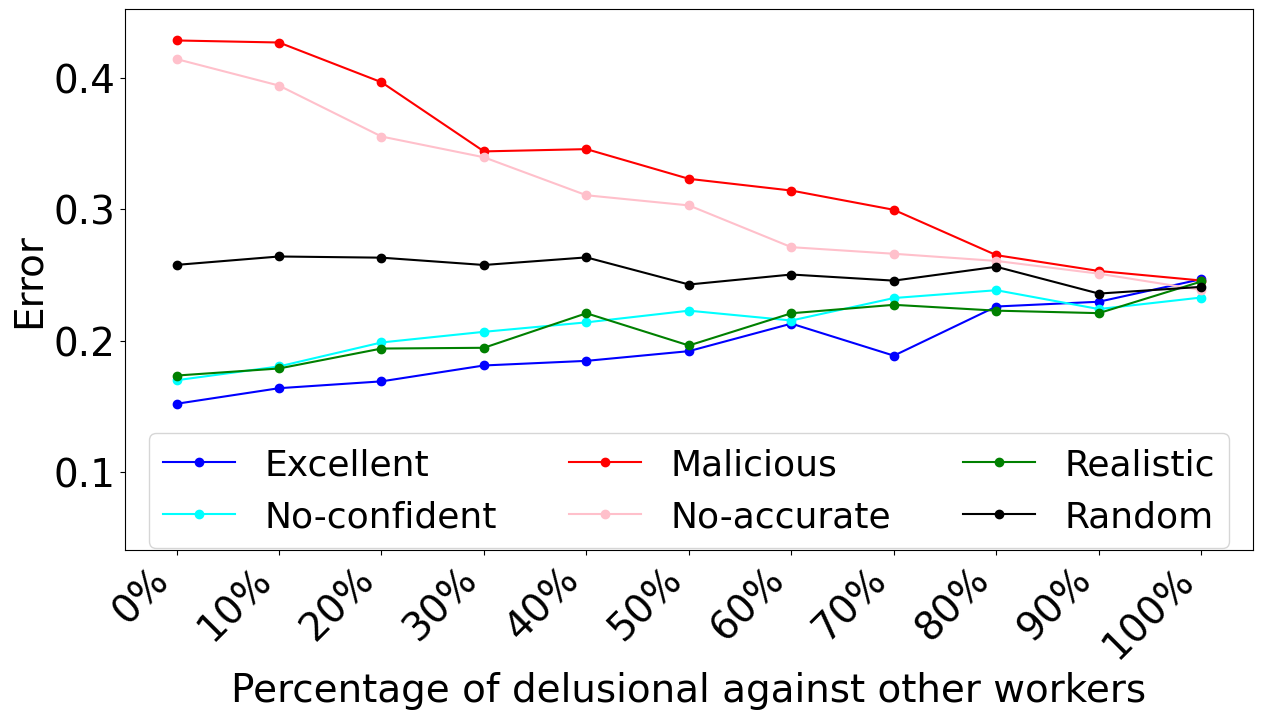

In [25]:
main_worker = 6
plot_experiment(final_errors[main_worker], "Percentage of delusional against other workers", main_worker=main_worker, min_y=min_error, max_y=max_error, save_file=save_file)